In [1]:
import os
import sys
#sys.path.insert(0, os.path.dirname(os.getcwd()))
import pickle

import numpy as np
import torch
#import torch.cuda
import timeit
import pandas as pd
#import argparse
import itertools
from load_data import load_data # segment_SHAP
from evaluation.metrics.order_change import OrderChange_metric
from models.predictor_utils import load_predictor
from pickle import dump



In [2]:
# PATHS
datasets_folder_path = None
attributions_folder_path = None
trained_models_folder_path = None
save_results_folder_path = None

In [3]:
demo_mode = False

In [4]:
# settings
dataset_names = ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"]    #[sys.argv[1]] # ['UWAVE', "KeplerLightCurves", "MP8", "gunpoint", "EOG"] 
predictor_names = ["randomForest", 'miniRocket', 'resNet', "QUANT"] #['resNet']    #[sys.argv[2]] 
segmentation_names = ["clasp","greedygaussian", "equal", "infogain","nnsegment"] # ["clasp","greedygaussian", "equal", "infogain","nnsegment"] 
background_names =  ["average"] #["average", "zero", "sampling"]
normalization_names = ["default", "normalized"]

eval_metric = OrderChange_metric()
metric_name = "order_change"
results_prefix = "order_change" #"evaluation"


demo_mode_samples = 25
# demo
if demo_mode:
    dataset_names = ['UWAVE']
    predictor_names = ['resNet'] #['randomForest', 'resNet', 'miniRocket']
    segmentation_names = ['nnsegment']
    background_names = ["average"]#, 'zero','sampling']
    normalization_names = ["default", "normalized"]

# optional
# # get infos about which explanations are evaluated
# datasets = list( explanations['attributions'].keys() )
# segmentations = list( explanations['attributions'][datasets[0]].keys() )
# predictors = list( explanations['attributions'][datasets[0]][segmentations[0]].keys() )
# backgrounds = list( explanations['attributions'][datasets[0]][segmentations[0]][predictors[0]].keys() )
# result_types = ['default','normalized']

In [5]:
# column_names = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric', 'Perturb', "Result"]
# df = pd.DataFrame(data=data_list, columns = column_names)

In [6]:
# df

In [7]:
cwd = os.getcwd()
if datasets_folder_path is None:
    datasets_folder_path = "datasets" #os.path.join(cwd, "datasets")
if attributions_folder_path is None:
    attributions_folder_path = "attributions"
if trained_models_folder_path is None:
    trained_models_folder_path = "trained_models"
if save_results_folder_path is None:
    save_results_folder_path = os.path.join("evaluation", "results", results_prefix + "_results")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

starttime = timeit.default_timer()


for dataset_name in dataset_names:
    print("Dataset: ", dataset_name)
    # loading dataset
    X_train, X_test, y_train, y_test, enc = load_data(subset='all', dataset_name=dataset_name, path=datasets_folder_path)
    if demo_mode:
        X_test, y_test = X_test[:demo_mode_samples], y_test[:demo_mode_samples]

    eval_metric.fit_data(X_train, X_test, y_train, y_test)

    for predictor_name in predictor_names:
        print("Predictor: ", predictor_name)

        # load classifier
        predictor = load_predictor(path=trained_models_folder_path, predictor_name=predictor_name, dataset_name=dataset_name, device=device) # torch.device(device)

        # load explanations
        attribution_filename = "_".join(("all_results", dataset_name, predictor_name)) + ".npy"
        explanations = np.load(os.path.join(attributions_folder_path, attribution_filename), allow_pickle=True).item() # FileNotFoundError
        label_mapping = explanations['label_mapping'][dataset_name]

        eval_metric.fit_ml_model(predictor)

        data_list = []

        for key in itertools.product(segmentation_names, background_names):
            segmentation_name, background_name = key
            print("assessing", key)

            # load model and explanations to access
            default_attributions = explanations['attributions'][dataset_name][segmentation_name][predictor_name][background_name]["default"]
            normalized_attributions = explanations['attributions'][dataset_name][segmentation_name][predictor_name][background_name]["normalized"]
            # y_test_pred = explanations['y_test_pred'][dataset_name][predictor_name]
            segments = explanations['segments'][dataset_name][segmentation_name]


            results = eval_metric.evaluate(default_attributions, normalized_attributions, segments)

            for result_tuple in results:
                data_list.append((dataset_name, segmentation_name, predictor_name, metric_name) + result_tuple)

            print("elapsed time", (timeit.default_timer() - starttime))

        # save
        column_names = ['Dataset', 'Segmentation', 'ML model', 'Metric', 'Perturb', "Result"]
        df = pd.DataFrame(data=data_list, columns = column_names)
        file_name = "_".join((results_prefix, dataset_name, predictor_name))
        result_path = os.path.join(save_results_folder_path, file_name)
        if not demo_mode:
            df.to_csv(result_path)
            # with open( "_".join( (dataset_name,classifier_name)) ,"wb") as f:
            #     pickle.dump(results_dict, f)

Dataset:  UWAVE
Predictor:  randomForest
assessing ('clasp', 'average')
elapsed time 2.644736299989745
assessing ('greedygaussian', 'average')
elapsed time 2.6548332000384107
assessing ('equal', 'average')
elapsed time 2.665015200036578
assessing ('infogain', 'average')
elapsed time 2.675122300046496
assessing ('nnsegment', 'average')
elapsed time 2.685320600052364
Predictor:  miniRocket
assessing ('clasp', 'average')
elapsed time 2.7550192000344396
assessing ('greedygaussian', 'average')
elapsed time 2.765548800001852
assessing ('equal', 'average')
elapsed time 2.778513600002043
assessing ('infogain', 'average')
elapsed time 2.7912391000427306
assessing ('nnsegment', 'average')
elapsed time 2.802063300041482
Predictor:  resNet
assessing ('clasp', 'average')
elapsed time 2.888800000073388
assessing ('greedygaussian', 'average')
elapsed time 2.904324200004339
assessing ('equal', 'average')
elapsed time 2.9158473000861704
assessing ('infogain', 'average')
elapsed time 2.929179200087674
a

In [8]:
df.head()

,Dataset,Segmentation,ML model,Metric,Perturb,Result
0,EOG,clasp,QUANT,order_change,fraction,0.883978
1,EOG,greedygaussian,QUANT,order_change,fraction,0.983425
2,EOG,equal,QUANT,order_change,fraction,0.000000
3,EOG,infogain,QUANT,order_change,fraction,0.980663
4,EOG,nnsegment,QUANT,order_change,fraction,0.922652


In [9]:
# 0/0

In [10]:
save_results_folder_path

'evaluation\\results\\order_change_results'

In [12]:
path = os.path.join(save_results_folder_path)
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df = merged_df
df

,Dataset,Segmentation,ML model,Metric,Perturb,Result
0,EOG,clasp,miniRocket,order_change,fraction,0.936464
1,EOG,greedygaussian,miniRocket,order_change,fraction,0.936464
2,EOG,equal,miniRocket,order_change,fraction,0.000000
3,EOG,infogain,miniRocket,order_change,fraction,0.988950
4,EOG,nnsegment,miniRocket,order_change,fraction,0.947514
...,...,...,...,...,...,...
0,UWAVE,clasp,resNet,order_change,fraction,0.995327
1,UWAVE,greedygaussian,resNet,order_change,fraction,0.992991
2,UWAVE,equal,resNet,order_change,fraction,0.000000
3,UWAVE,infogain,resNet,order_change,fraction,1.000000


In [14]:
import matplotlib.pyplot as plt

In [ ]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
metric_names = ['F_score', 'AUCSE_top']

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (25,8), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3_mean = df3[("Result", "mean")]
        df3_std = df3[("Result", "std")]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=45)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(metric_name)

Entropy

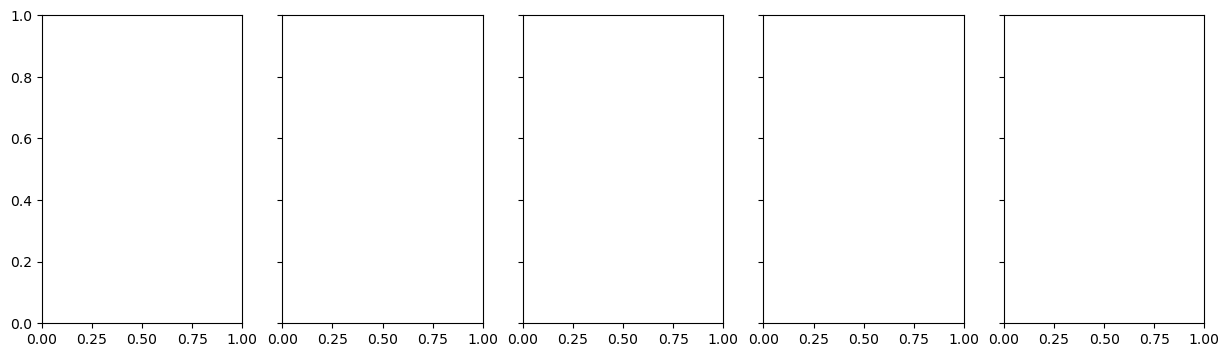

In [17]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

mask = (df["Metric"]=="order_change")
df2 = df.loc[mask, ["Dataset", "Segmentation", "ML model", "Result"]]


df3 = df2.groupby(["Dataset", "Segmentation"]).agg({'Result': ["mean", "std"]}).reset_index()

# for i, dataset_name in enumerate(dataset_names):

#     mask = (df2["Dataset"]==dataset_name)
    
#     ax[i].set_title(dataset_name)

#     mask = (df3["Perturb"]=="fraction")
#     df4 = df3.loc[mask, ["Segmentation", "Result"]]

#     x = df4["Segmentation"].values
#     y = df4["Result"].values

#     ax[i].bar(x, y)
#     ax[i].grid()
#     ax[i].tick_params("x", rotation=45)

# fig.suptitle("Percentage of samples where normalization results in change of order of importance over Segmentations for each Dataset")
# fig.tight_layout()

In [20]:
df3

Dataset    Segmentation    Result          
                                           mean       std
0                 EOG           clasp  0.825276  0.127718
1                 EOG           equal  0.000000  0.000000
2                 EOG  greedygaussian  0.910912  0.061289
3                 EOG        infogain  0.953729  0.042520
4                 EOG       nnsegment  0.874309  0.074756
5   KeplerLightCurves           clasp  0.807644  0.025671
6   KeplerLightCurves           equal  0.129699  0.064724
7   KeplerLightCurves  greedygaussian  0.994987  0.006139
8   KeplerLightCurves        infogain  0.995614  0.005922
9   KeplerLightCurves       nnsegment  0.884712  0.065387
10                MP8           clasp  1.000000  0.000000
11                MP8           equal  0.905462  0.060758
12                MP8  greedygaussian  0.997059  0.003971
13                MP8        infogain  1.000000  0.000000
14                MP8       nnsegment  1.000000  0.000000
15              UWAVE           clasp  0.998248  0.002237
16              UWAVE           equal  0.008762  0.010514
17              UWAVE  greedygaussian  0.993575  0.003990
18              UWAVE        infogain  0.999416  0.001168
19              UWAVE       nnsegment  0.995911  0.003990
20           gunpoint           clasp  0.480000  0.107634
21           gunpoint           equal  0.000000  0.000000
22           gunpoint  greedygaussian  0.138333  0.085440
23           gunpoint        infogain  0.243333  0.187023
24           gunpoint       nnsegment  0.240000  0.128351

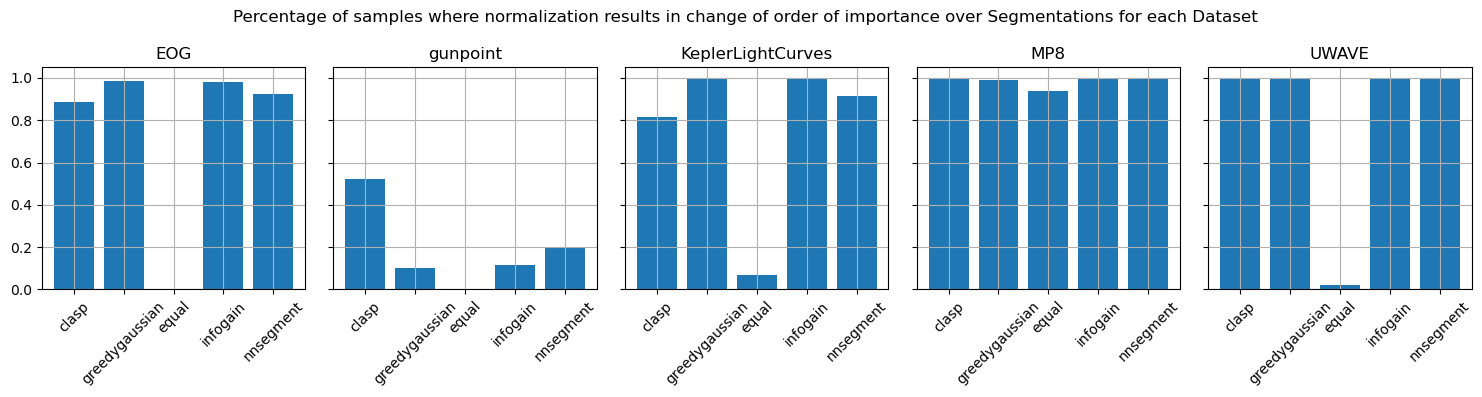

In [ ]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="order_change")
df2 = df.loc[mask, ["Dataset", "Segmentation", "ML model", "Perturb", "Result"]]

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask = (df2["Dataset"]==dataset_name)
    df3 = df2.loc[mask, ["Segmentation", "Perturb", "Result"]]
    ax[i].set_title(dataset_name)

    mask = (df3["Perturb"]=="fraction")
    df4 = df3.loc[mask, ["Segmentation", "Result"]]

    x = df4["Segmentation"].values
    y = df4["Result"].values

    ax[i].bar(x, y)
    ax[i].grid()
    ax[i].tick_params("x", rotation=45)

fig.suptitle("Percentage of samples where normalization results in change of order of importance over Segmentations for each Dataset")
fig.tight_layout()